## 빅데이터 활용 AI 설계
# DCGAN : MNIST

- GAN : Generative Adversarial Networks
- DCGAN : Deep Convolutional GAN
- Generator(생성자) / Discriminator(판별자)

<img src='https://skymind.ai/images/wiki/GANs.png' />
(출처 : https://skymind.ai/wiki/generative-adversarial-network-gan?fbclid=IwAR0V4kAn9b5GReI9F-OWSUtRPOUgKuWasqPJvuhgL-4ihot_OqYSNAeKd6Y)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### MNIST 로딩

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
X_train = X_train/255
X_test = X_test/255

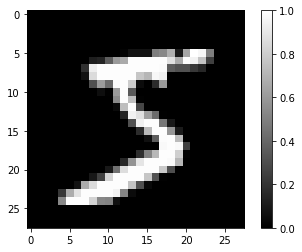

In [22]:
plt.imshow(X_train[0], cmap='gray')
plt.colorbar()

In [6]:
X_train = X_train[:,:,:,np.newaxis] # X_train.reshape(-1,28,28,1)
X_test = X_test[:,:,:,np.newaxis]

In [7]:
X_train.shape, X_train.dtype, X_train.max(), X_train.min()

((60000, 28, 28, 1), dtype('float64'), 1.0, 0.0)

In [8]:
X_test.shape

(10000, 28, 28, 1)

### 판별자 정의

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.optimizers import RMSprop

In [10]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         2

<img src='https://www.researchgate.net/profile/Sepp_Hochreiter/publication/284579051/figure/fig1/AS:614057178578955@1523414048184/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs.png' />
(출처: https://www.researchgate.net/figure/The-rectified-linear-unit-ReLU-the-leaky-ReLU-LReLU-a-01-the-shifted-ReLUs_fig1_284579051)

In [11]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 생성자 정의

In [12]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       51

### 적대망 정의
- 생성자로 생성한 이미지가 판별자에 의해 '실제이미지' 로 판별되도록 생성자의 가중치를 조절한다

In [13]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         1301505   
_________________________________________________________________
model_1 (Model)              (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [14]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

### 훈련하기
- fake images: 0, real images: 1
- 1 step 에 10초 정도 소요됨
- C:\khh\프로그래밍\CNN\gan_images 폴더에 'fake_9.png' 형태로 저장함
- 생성자 모델을 'gan_mnist_generator_1000.h5' 로 저장함

In [15]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(20): # 400
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

C:\Anaconda3\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001,  [0.6926977, 0.2890625, 1.0251112, 0.0]


C:\Anaconda3\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00002,  [0.6380305, 0.5, 1.0652347, 0.0]
Step: 00003,  [0.5411577, 1.0, 1.4819052, 0.0]
Step: 00004,  [0.4187925, 0.9609375, 1.3302001, 0.0]
Step: 00005,  [0.30871677, 1.0, 2.845601, 0.0]
Step: 00006,  [0.25620753, 0.9453125, 1.157366, 0.0]
Step: 00007,  [0.19986457, 0.9921875, 2.9595304, 0.0]
Step: 00008,  [0.13915533, 0.984375, 1.5469143, 0.0]
Step: 00009,  [0.09333084, 0.9921875, 1.1590295, 0.0]
Step: 00010,  [0.0525401, 1.0, 0.91476834, 0.015625]
Step: 00011,  [0.07001501, 0.9921875, 0.37281543, 1.0]
Step: 00012,  [0.05520773, 0.9921875, 0.92688966, 0.03125]
Step: 00013,  [0.04486181, 0.984375, 0.29486033, 1.0]
Step: 00014,  [0.026731027, 1.0, 0.23420426, 1.0]
Step: 00015,  [0.023039985, 1.0, 0.21694629, 1.0]
Step: 00016,  [0.02808114, 0.9921875, 0.11981237, 1.0]
Step: 00017,  [0.02338395, 0.9921875, 0.14345613, 1.0]
Step: 00018,  [0.024605528, 0.9921875, 0.09054917, 1.0]
Step: 00019,  [0.024670277, 1.0, 0.123630874, 1.0]
Step: 00020,  [0.014267772, 1.0, 0.12170452, 1.0]


In [16]:
generator.save('gan_mnist_generator_20.h5')

- 총 1000번 배치 실행 (이전 400번 + 신규 600번)

In [17]:
from keras.preprocessing import image

batch_size = 64

for step in range(400,1000): # 40000
    idx = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

Step: 00401, [0.018, 1.000, 0.059, 1.000]
Step: 00402, [0.025, 0.992, 0.155, 1.000]
Step: 00403, [0.023, 1.000, 0.016, 1.000]
Step: 00404, [0.068, 1.000, 5.817, 0.000]
Step: 00405, [0.320, 0.883, 0.087, 1.000]
Step: 00406, [0.756, 0.516, 6.724, 0.000]
Step: 00407, [0.611, 0.773, 2.305, 0.000]
Step: 00408, [0.147, 0.945, 1.411, 0.031]
Step: 00409, [0.169, 0.953, 1.268, 0.062]
Step: 00410, [0.112, 0.977, 1.054, 0.141]
Step: 00411, [0.186, 0.945, 1.897, 0.000]
Step: 00412, [0.213, 0.930, 1.892, 0.000]
Step: 00413, [0.348, 0.914, 3.775, 0.000]
Step: 00414, [0.447, 0.875, 1.889, 0.000]
Step: 00415, [0.411, 0.773, 6.372, 0.000]
Step: 00416, [1.190, 0.617, 1.440, 0.000]
Step: 00417, [0.862, 0.500, 4.638, 0.000]
Step: 00418, [0.889, 0.688, 2.023, 0.000]
Step: 00419, [0.630, 0.445, 2.674, 0.000]
Step: 00420, [0.565, 0.852, 2.003, 0.000]
Step: 00421, [0.508, 0.578, 2.941, 0.000]
Step: 00422, [0.537, 0.898, 1.985, 0.000]
Step: 00423, [0.483, 0.570, 2.972, 0.000]
Step: 00424, [0.527, 0.875, 1.812,

KeyboardInterrupt: 

In [ ]:
generator.save('gan_mnist_generator_1000.h5')

In [ ]:
np.save('gan_mnist_log.npy', logs)

### 결과 분석

In [ ]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

In [ ]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

- 결과 비교
<img src='https://d33wubrfki0l68.cloudfront.net/1439d140302850f4652f4def43d264b7afa39e65/81f84/assets/images/gan-intro/mnistkeras_19_0.png' />
(출처: https://www.wouterbulten.nl/blog/tech/getting-started-with-generative-adversarial-networks/)

### 숫자 이미지 생성

In [ ]:
from keras.models import load_model

#generator = load_model('gan_mnist_generator_1000.h5')

In [ ]:
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')

### Fashion MNIST

In [ ]:
from keras.datasets.fashion_mnist import load_data

In [ ]:
fmnist = load_data()

In [ ]:
fmnist[1][0].shape